In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [27]:
# Load datasets
fed_files = ['CPIAUCSL.csv', 'RRVRUSQ156N.csv', 'MORTGAGE30US.csv', 'MSPUS.csv', 
             'USAUCSFRCONDOSMSAMID.csv', 'GDPC1.csv', 'UNRATE.csv', 'PI.csv', 
             'POPTOTUSA647NWDB.csv', 'CSUSHPISA.csv']
data_frames = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

In [28]:
data = pd.concat(data_frames, axis=1)
data = data.ffill().dropna()

In [29]:
data.columns = ['CPI', 'RentalVacancyRate', 'MortgageRate', 'MedianSalePrice', 'ZillowIndex', 
                 'GDP', 'UnemploymentRate', 'PersonalIncome', 'Population', 'HomePriceIndex']
data

,CPI,RentalVacancyRate,MortgageRate,MedianSalePrice,ZillowIndex,GDP,UnemploymentRate,PersonalIncome,Population,HomePriceIndex
DATE,,,,,,,,,,
2004-01-08,186.300,10.4,5.87,212700.0,163387.988490,15248.680,5.7,9731.8,292805298.0,141.647
2004-01-15,186.300,10.4,5.66,212700.0,163387.988490,15248.680,5.7,9731.8,292805298.0,141.647
2004-01-22,186.300,10.4,5.64,212700.0,163387.988490,15248.680,5.7,9731.8,292805298.0,141.647
2004-01-29,186.300,10.4,5.68,212700.0,163387.988490,15248.680,5.7,9731.8,292805298.0,141.647
2004-02-01,186.700,10.4,5.68,212700.0,164448.866854,15248.680,5.6,9765.4,292805298.0,143.192
...,...,...,...,...,...,...,...,...,...,...
2024-03-21,312.230,6.6,6.87,426800.0,359543.076444,22758.752,3.8,23746.6,334914895.0,318.217
2024-03-28,312.230,6.6,6.79,426800.0,359543.076444,22758.752,3.8,23746.6,334914895.0,318.217
2024-04-01,313.207,6.6,6.79,412300.0,361420.150687,22918.739,3.9,23809.6,334914895.0,319.048


In [30]:
# Ensure the date index has frequency information
data.index = pd.to_datetime(data.index)
data = data.asfreq('MS')  # Monthly Start frequency

In [31]:
# Create new feature: normalized home price index
data['NormalizedHomePriceIndex'] = data['HomePriceIndex'] / data['CPI']

In [32]:
# Add lag features
for lag in range(1, 13):
    data[f'HomePriceIndex_Lag_{lag}'] = data['HomePriceIndex'].shift(lag)

In [33]:
# Drop rows with missing values created by lag features
data = data.dropna()

In [34]:
# Verify if data is correctly processed
print(f"Data after preprocessing: {data.shape}")
print(data.head())

Data after preprocessing: (233, 23)
              CPI  RentalVacancyRate  MortgageRate  MedianSalePrice  \
DATE                                                                  
2005-02-01  192.4               10.1          5.66         232500.0   
2005-03-01  193.1               10.1          5.69         232500.0   
2005-04-01  193.7                9.8          6.04         233700.0   
2005-05-01  193.6                9.8          5.78         233700.0   
2005-06-01  193.7                9.8          5.65         233700.0   

              ZillowIndex        GDP  UnemploymentRate  PersonalIncome  \
DATE                                                                     
2005-02-01  182971.283783  15844.727               5.4         10282.7   
2005-03-01  184533.914455  15844.727               5.2         10347.9   
2005-04-01  186294.280193  15922.782               5.2         10412.1   
2005-05-01  188164.303058  15922.782               5.1         10464.1   
2005-06-01  190122.978

In [35]:
# Features and target variable
X = data.drop(columns=['HomePriceIndex'])
y = data['HomePriceIndex']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

In [37]:
# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Linear Regression
cv_scores_lr = cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_cv_lr = -cv_scores_lr.mean()

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_cv_rf = -cv_scores_rf.mean()

In [38]:
# Fit models on the entire training set
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)

In [39]:
# Ensemble predictions by averaging
y_pred_ensemble = (y_pred_lr + y_pred_rf) / 2

# Stacking Regressor
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

param_grid_gbr = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_

estimators = [
    ('lr', lr),
    ('rf', best_rf),
    ('gbr', best_gbr)
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_regressor.fit(X_train, y_train)

# Predictions
y_pred_stacking = stacking_regressor.predict(X_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [40]:
# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{model_name} - MSE: {mse:.4f}')
    print(f'{model_name} - R2: {r2:.4f}')
    print(f'{model_name} - MAE: {mae:.4f}')

# Evaluate each model
evaluate_model(y_test, y_pred_lr, 'Linear Regression')
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_gbr, 'Gradient Boosting')
evaluate_model(y_test, y_pred_ensemble, 'Ensemble Model')
evaluate_model(y_test, y_pred_stacking, 'Stacking Ensemble Model')

Linear Regression - MSE: 0.1508
Linear Regression - R2: 0.9999
Linear Regression - MAE: 0.2783
Random Forest - MSE: 1.8930
Random Forest - R2: 0.9993
Random Forest - MAE: 0.8921
Gradient Boosting - MSE: 2.3872
Gradient Boosting - R2: 0.9991
Gradient Boosting - MAE: 1.1100
Ensemble Model - MSE: 0.4940
Ensemble Model - R2: 0.9998
Ensemble Model - MAE: 0.4716
Stacking Ensemble Model - MSE: 0.1342
Stacking Ensemble Model - R2: 0.9999
Stacking Ensemble Model - MAE: 0.2581


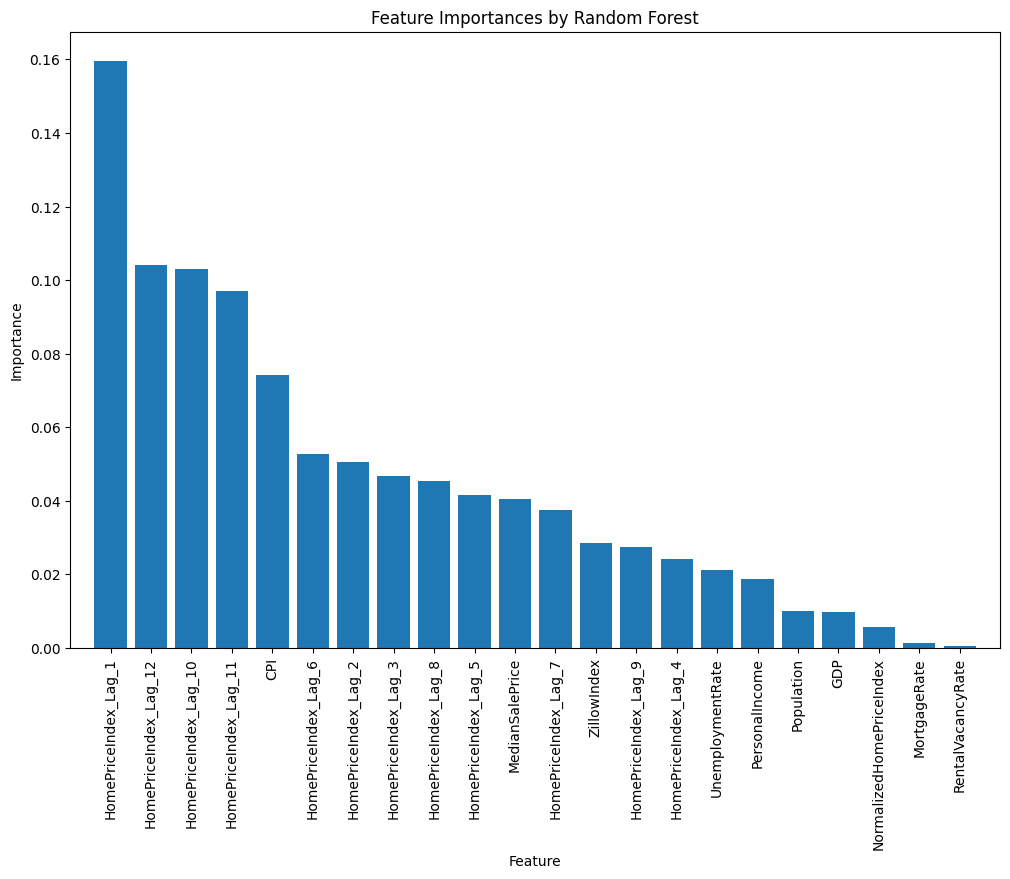

In [42]:
# Plot feature importances for Random Forest
plt.figure(figsize=(12, 8))
importances = best_rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.title('Feature Importances by Random Forest')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

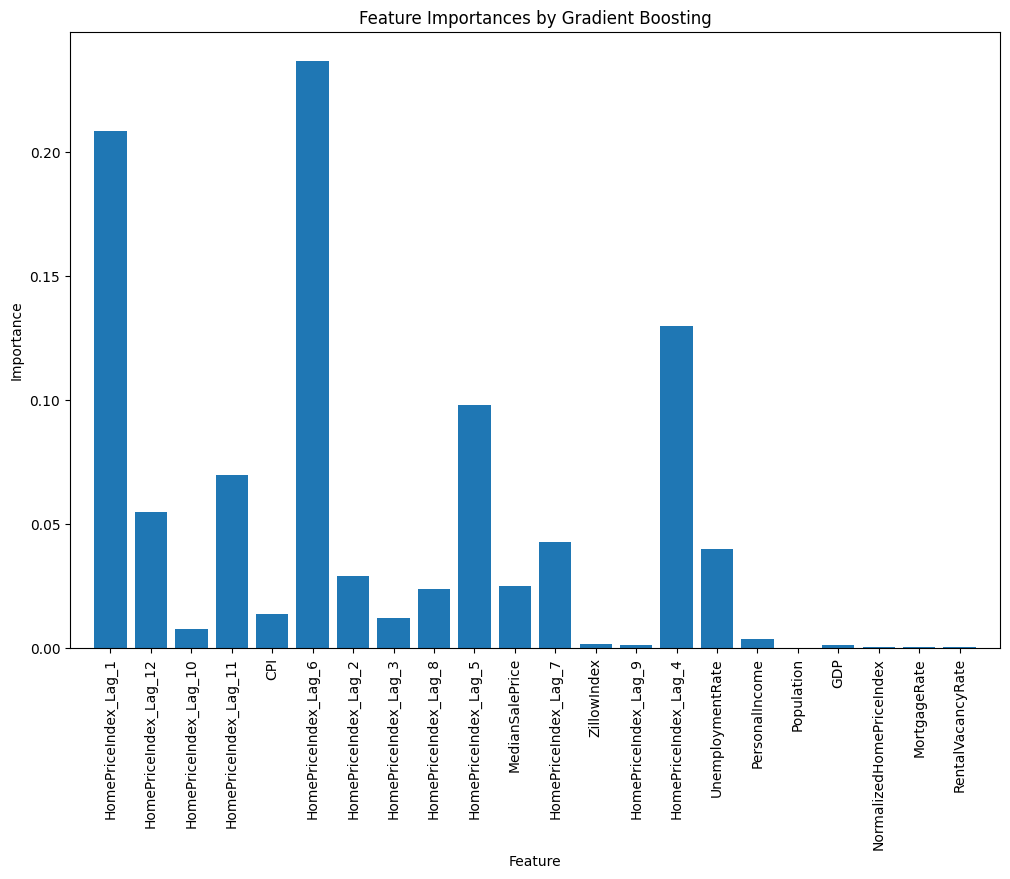

In [43]:
# Plot feature importances for Gradient Boosting
plt.figure(figsize=(12, 8))
importances = best_gbr.feature_importances_
plt.title('Feature Importances by Gradient Boosting')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
The above plot represents the feature importance of Gradient Boosting model

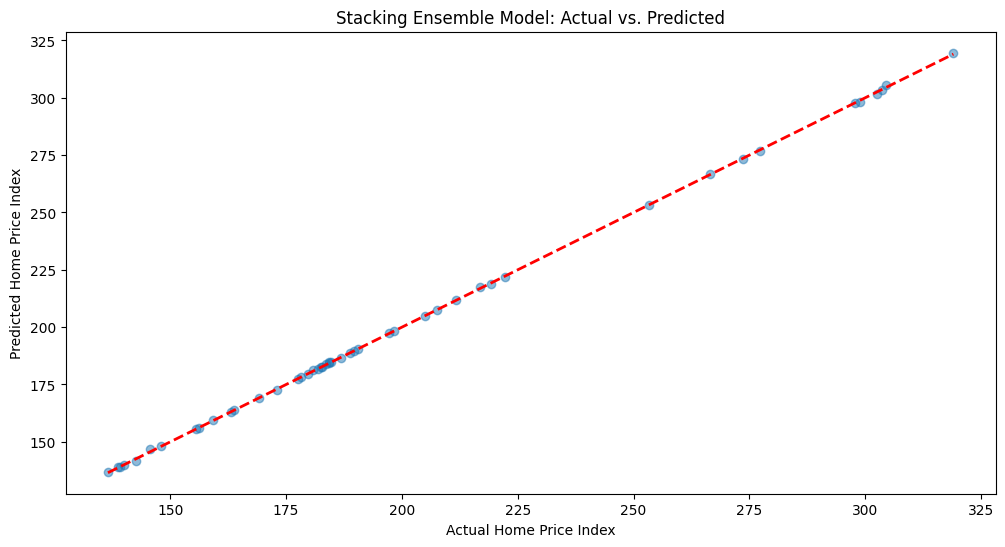

In [44]:
# Plot predictions vs. actual values for Stacking Ensemble Model
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Home Price Index')
plt.ylabel('Predicted Home Price Index')
plt.title('Stacking Ensemble Model: Actual vs. Predicted')
plt.show()

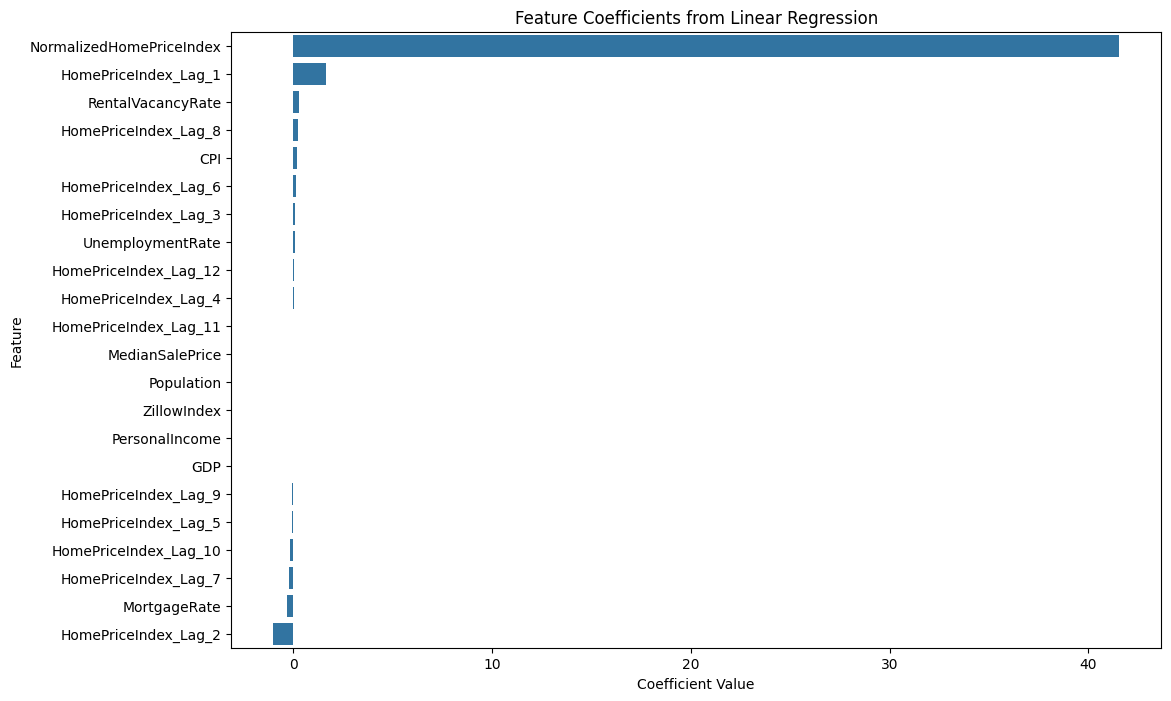

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Get feature coefficients
coefficients = lr.coef_
features = X.columns

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot feature coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

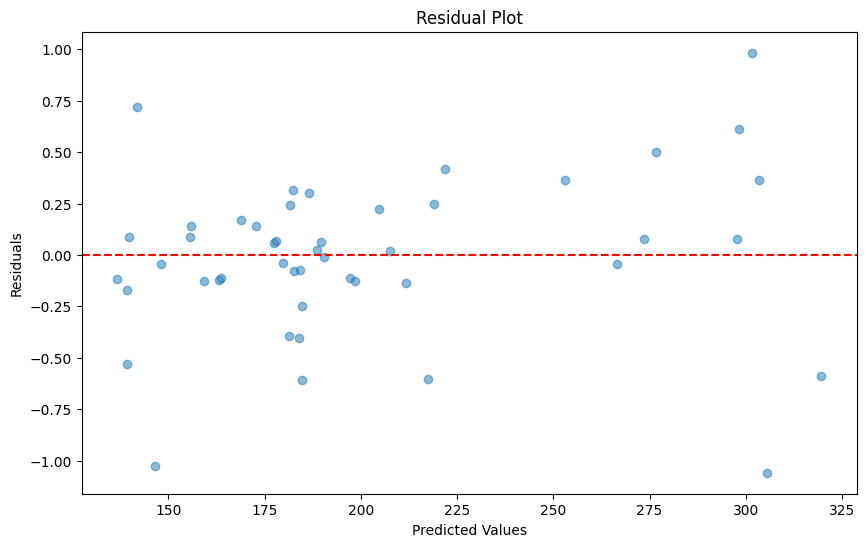

In [48]:
# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred_lr

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

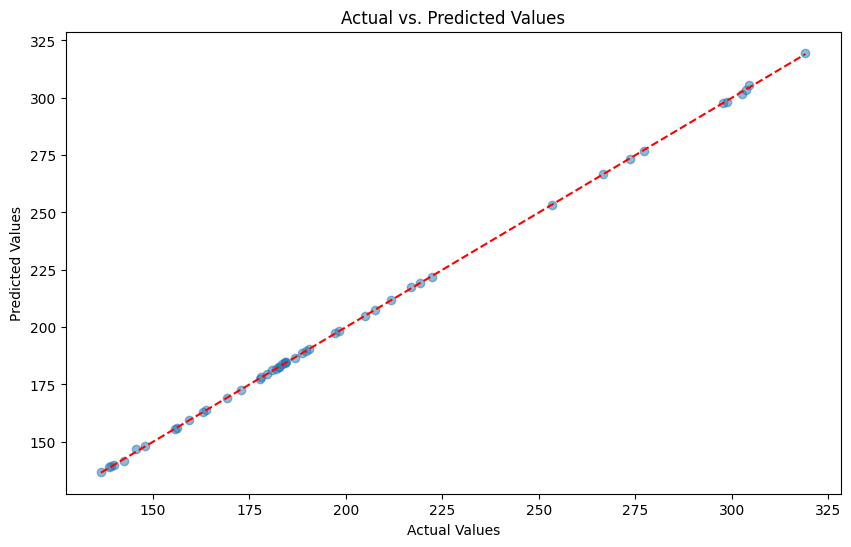

In [49]:
# Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

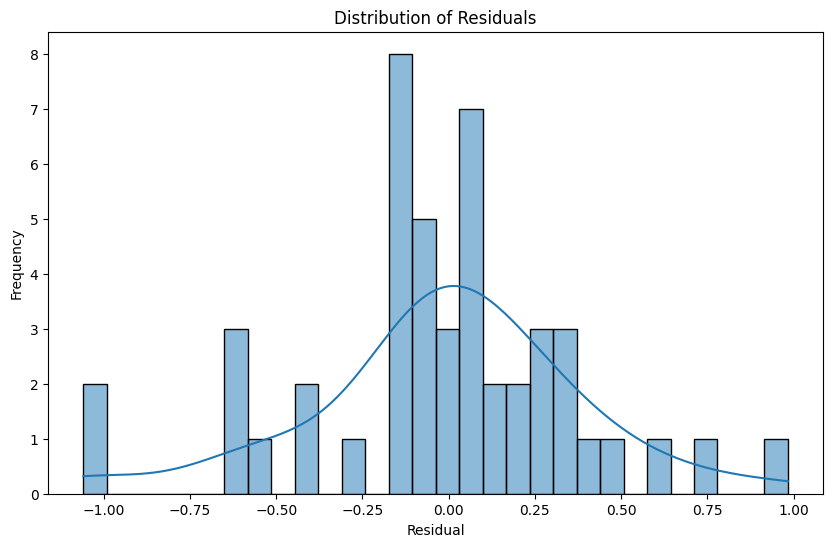

In [50]:
# Plot Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

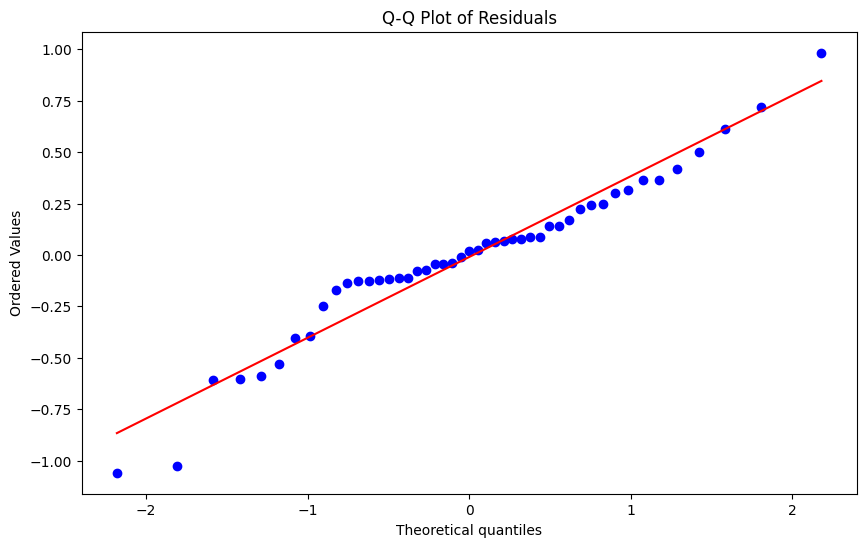

In [51]:
import scipy.stats as stats

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

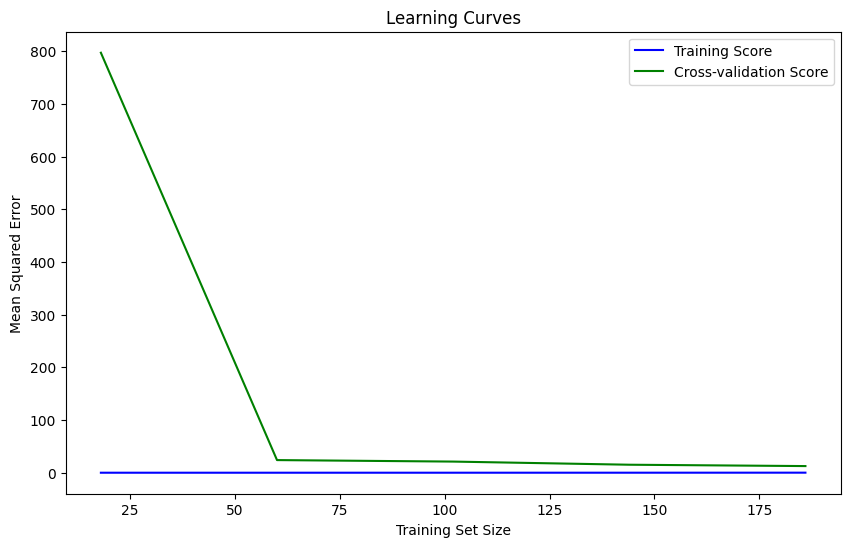

In [52]:
from sklearn.model_selection import learning_curve

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(lr, X, y, cv=5, scoring='neg_mean_squared_error')

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Score', color='blue')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Cross-validation Score', color='green')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

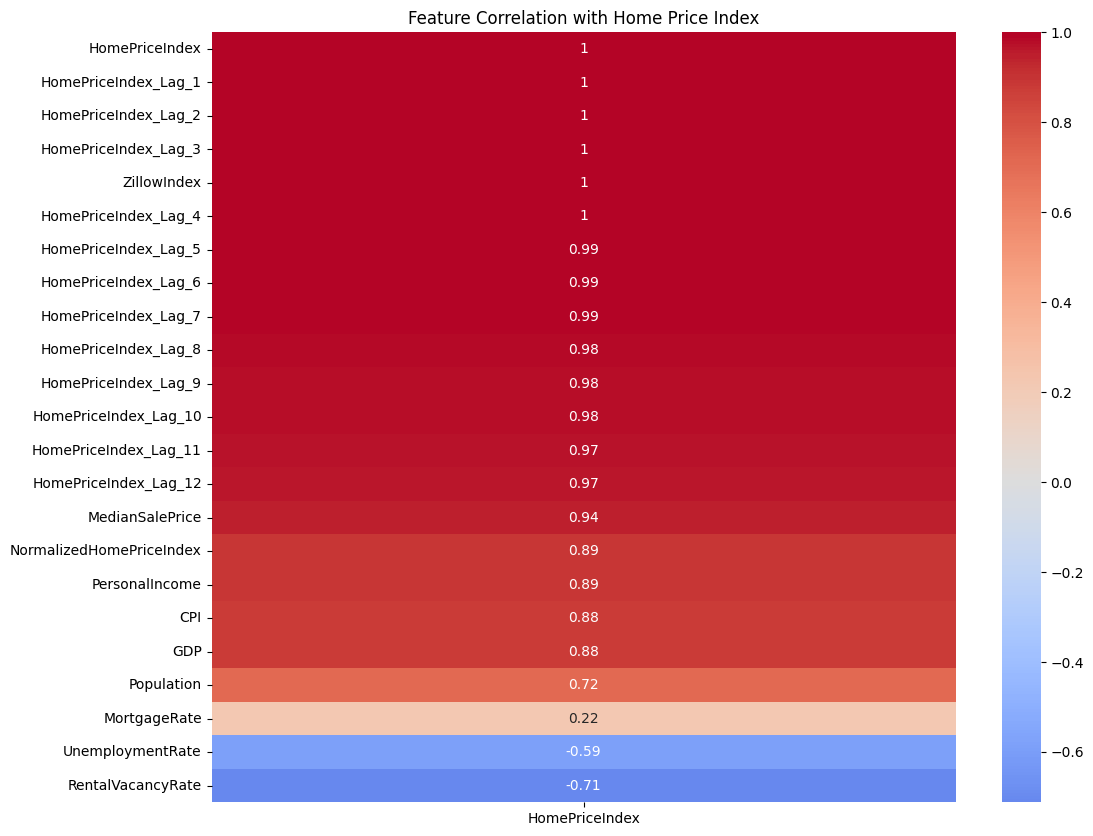

In [53]:
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = X.copy()
correlation_matrix['HomePriceIndex'] = y
correlation_matrix = correlation_matrix.corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['HomePriceIndex']].sort_values(by='HomePriceIndex', ascending=False), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Home Price Index')
plt.show()

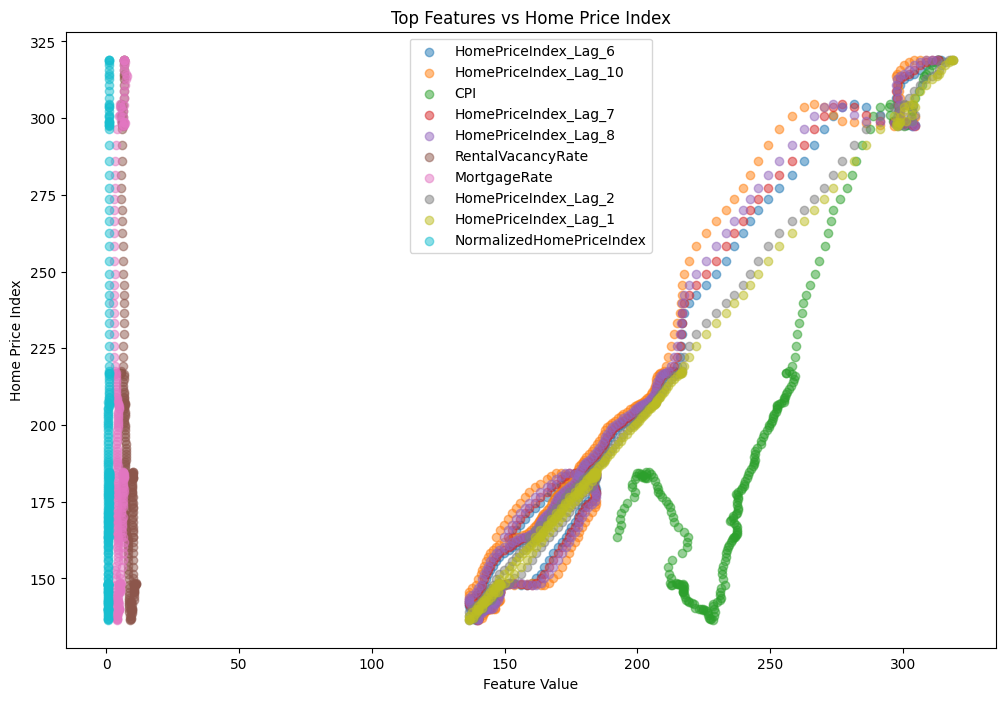

In [57]:
# Sort features by coefficient magnitude
feature_names = X.columns
sorted_indices = np.argsort(np.abs(coefficients))
top_features = feature_names[sorted_indices][-10:]  # Get top 10 features
top_coefficients = coefficients[sorted_indices][-10:]

# Plot Top Features vs Target
plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.scatter(X[feature], y, label=feature, alpha=0.5)
plt.xlabel('Feature Value')
plt.ylabel('Home Price Index')
plt.title('Top Features vs Home Price Index')
plt.legend()
plt.show()